In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.dates as mdates
from datetime import timedelta 
import datetime
from matplotlib.colors import rgb2hex
import os
import numpy as np
import seaborn as sns; sns.set()
from pyecharts.charts import Bar, Pie, Map, WordCloud, Geo
from pyecharts import options as opts
from pyecharts.globals import ChartType, SymbolType
from snapshot_selenium import snapshot
from pyecharts.render import make_snapshot
from __future__ import unicode_literals
from pyecharts.globals import CurrentConfig, NotebookType
CurrentConfig.NOTEBOOK_TYPE = NotebookType.JUPYTER_NOTEBOOK
from pyecharts.commons.utils import JsCode
import plotly.figure_factory as ff # map of the US
import plotly.graph_objects as go
import plotly.express as px
import yfinance as yf # stock market
import us
from itertools import compress
import itertools
import import_ipynb
from utils_common import *
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from urllib.request import urlopen
import json

importing Jupyter notebook from utils_common.ipynb


In [2]:
# State level data of COVID-19
# https://github.com/nytimes/covid-19-data/blob/master/us-states.csv
_NYT_DATA_FILE_ = 'https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-states.csv'

# County level data of COVID-19
# https://github.com/nytimes/covid-19-data/blob/master/us-counties.csv
_NYT_DATA_County_FILE_ = 'https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv'

# Rural-Urban Continuum Codes
# https://www.ers.usda.gov/data-products/rural-urban-continuum-codes/
_UR_FILE_xls_ = './data_US/ruralurbancodes2013.xls'
# https://www2.census.gov/programs-surveys/popest/datasets/2010-2019/counties/totals/
_UR_FILE_csv_ = './data_US/co-est2019-alldata.csv'

# Where to save the dataframes and figures
_Data_PATH_ = './data_US/'
_Figure_PATH_ = './figures_US/'

In [3]:
# Calculate new confirmed, new dead, and new cured
def add_daily_new(df, group_keys=['state_name', 'county_name']):
    cols = ['confirmed', 'dead']
    daily_new = df.groupby(group_keys).agg(dict([(n, 'diff') for n in ['cum_' + c for c in cols]]))
    daily_new = daily_new.rename(columns=dict([('cum_' + n, 'new_' + n) for n in cols]))
    df = pd.concat([df, daily_new], axis=1, join='outer')
    return df

# Load data of COVID-19 
def load_NYT_raw():
    '''
    This provides a way to lookinto the 'raw' data
    '''
    raw = pd.read_csv(_NYT_DATA_FILE_)
    rename_dict = {'date': 'update_date',
                   'state': 'state_name',
                   'fips': 'fips',
                   'cases': 'cum_confirmed',
                   'deaths': 'cum_dead',
                  }
    data = raw.rename(columns=rename_dict)
    data['update_date'] = pd.to_datetime(data['update_date'])  # original type of update_time after read_csv is 'str'
    data['update_date'] = data['update_date'].dt.date
    data = add_daily_new(data, group_keys = ['state_name'])
    data = data.sort_values(['update_date', 'state_name'])
    data = data.reset_index(drop=True)
    print('Data date range: ', data['update_date'].min(), 'to', data['update_date'].max())
    print('Number of rows in raw data: ', data.shape[0])
    return data

def load_NYT_county_raw():
    '''
    This provides a way to lookinto the 'raw' data
    '''
    raw = pd.read_csv(_NYT_DATA_County_FILE_)
    rename_dict = {'date': 'update_date',
                   'county': 'county_name',
                   'state': 'state_name',
                   'fips': 'fips',
                   'cases': 'cum_confirmed',
                   'deaths': 'cum_dead',
                  }
    data = raw.rename(columns=rename_dict)
    data['update_date'] = pd.to_datetime(data['update_date'])  # original type of update_time after read_csv is 'str'
    data['update_date'] = data['update_date'].dt.date
    data = add_daily_new(data, group_keys = ['state_name', 'county_name'])
    data = data.sort_values(['update_date', 'state_name', 'county_name'])
    data = data.reset_index(drop=True)
    print('Data date range: ', data['update_date'].min(), 'to', data['update_date'].max())
    print('Number of rows in raw data: ', data.shape[0])
    return data

In [4]:
data_state = load_NYT_raw()

Data date range:  2020-01-21 to 2020-05-27
Number of rows in raw data:  4744


In [5]:
data_county = load_NYT_county_raw()

Data date range:  2020-01-21 to 2020-05-27
Number of rows in raw data:  182670


In [6]:
data_state.to_csv(_Data_PATH_ + 'data_NYT_state.csv', index = False)
data_county.to_csv(_Data_PATH_ + 'data_NYT_county.csv', index = False)

In [7]:
# Number of counties that have infected cases so far
fips_infection = list(set(data_county.fips))
fips_infection += [293800, 36061] # add the fips for New York City and Kansas City
fips_infection.sort()
fips_infection = [int(x) for x in fips_infection if str(x) != 'nan']
len(fips_infection)

2948

In [8]:
# Is Grafton County (in NH) an Urbanized Area or an Urban Cluster or a Rural Area?
data_UR = pd.read_excel(_UR_FILE_xls_)
data_UR[data_UR['County_Name'] == 'Grafton County']

,FIPS,State,County_Name,Population_2010,RUCC_2013,Description
1768,33009,NH,Grafton County,89118,5,"Nonmetro - Urban population of 20,000 or more,..."


In [9]:
# Number of counties that do not have infected cases so far
data_UR[~data_UR['FIPS'].isin(fips_infection)].shape[0]

275

In [10]:
def figure_ur(df, subject, fsize = (10,12), fs = 16, title = None, country = 'US'):

    def urban_rural(n):
        if n>= 100000:
            return 'Urbanized Area A'
        elif n >= 50000:
            return 'Urbanized Area B'
        elif n >= 2500:
            return 'Urban Cluster'
        else:
            return 'Rural'
    df = data_county.copy()
    df.at[df.index[df['county_name'] == 'Kansas City'].tolist(), 'fips'] = 293800
    df.at[df.index[df['county_name'] == 'New York City'].tolist(), 'fips'] = 36061
    df = df[(df['county_name']!='Unknown') & (df['county_name']!='Kansas City')].copy()
    df = df[df['state_name'].isin(names_state)]
    df = df[df['fips'].isin(list(set(data_UR['FIPS'])))]
    df = df.reset_index(drop = True)
    df['population'] = df.apply(lambda row: data_UR[data_UR['FIPS'] == row.fips]['Population_2010'].tolist()[0], axis=1)
    df['type'] = df.apply(lambda row: urban_rural(row.population), axis=1)
    df = df.groupby(['update_date','type'])['cum_confirmed', 'population'].apply(lambda x : x.sum()).reset_index()
    df['cum_confirmed%'] = df.apply(lambda row: row.cum_confirmed/row.population*100, axis=1)

    ur_list = ['Urbanized Area A', 'Urbanized Area B', 'Urban Cluster', 'Rural']
    ur_title_list = ['Urbanized Area', 'Urbanized Area', 'Urban Cluster', 'Rural']
    pop_list = [r'$n \geq 100,000$', r'$50,000 \leq n < 100,000$', r'$2,500 \leq n < 50,000$', r'$n < 2,500$']
    color_list = ['#E385A9', '#F5D1BE', '#AEDADE']
    color_list = ['#679b9b', '#aacfcf', '#fde2e2', '#ffb6b6']
    fig, axes = plt.subplots(4, 1, figsize = fsize, sharey = False, sharex = True)
    sns.set_style("whitegrid")
    suffix = (lambda x: "" if x[-1] != '%' else "%")(subject)    
    
    for i, ur in enumerate(ur_list):
        ix = np.unravel_index(i, axes.shape)
        ax = axes[ix]
        df_single = df[df['type'] == ur].reset_index(drop = True)
        
        
        ax.plot(df_single['update_date'], df_single['cum_confirmed' + suffix], 
                        linewidth = 3, color = color_list[i], label = ur)
        ax.fill_between(df_single['update_date'], df_single['cum_confirmed' + suffix], 
                        color = color_list[i], label = None)
        if i == len(ur_list) - 1:
            ax.set_xlabel('Date', fontsize = fs - 2)
        if subject == 'R':
            ax.set_ylabel('Number', fontsize = fs - 2)
        else:
            ax.set_ylabel('Percentage', fontsize = fs - 2)
        
        ax.set_xlim(min(df.update_date), max(df.update_date))
        ax.xaxis.set_major_locator(mdates.DayLocator((1,15)))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))

        ax.set_title(ur_title_list[i] + ': ' + pop_list[i], fontsize = fs) 
    if subject == 'conf':
        fig.suptitle(title + ': urban and rural infection', fontsize = fs + 2, y = 0.95)   
    else:
        fig.suptitle(title + ': urban and rural infection%', fontsize = fs + 2, y = 0.95)  
    fig.align_ylabels(axes[0:])
    fig.subplots_adjust(hspace = 0.3, wspace = 0)
    
    fig.savefig(_Figure_PATH_ + 'figures_us_be/' + country + '_UR_' + subject.replace("%", "_percentage") + '.png', dpi = 400, bbox_inches='tight')

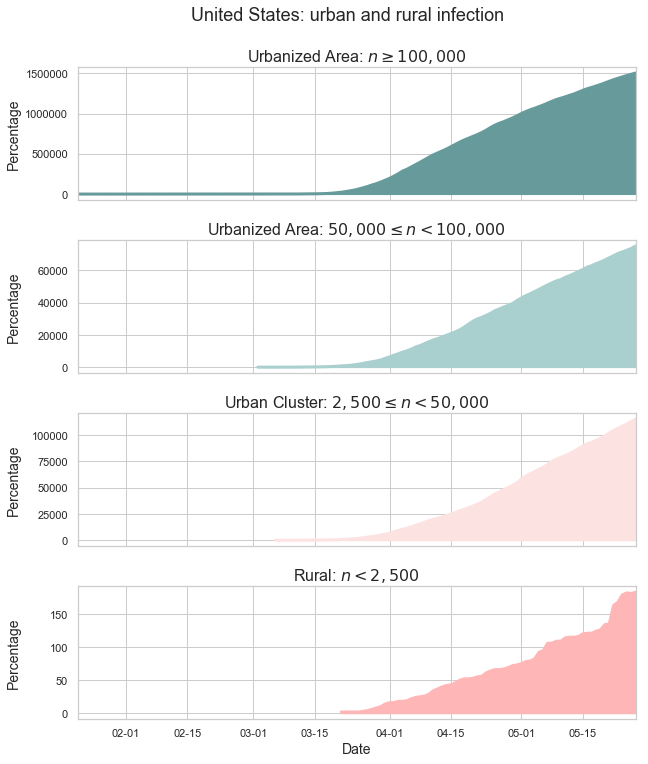

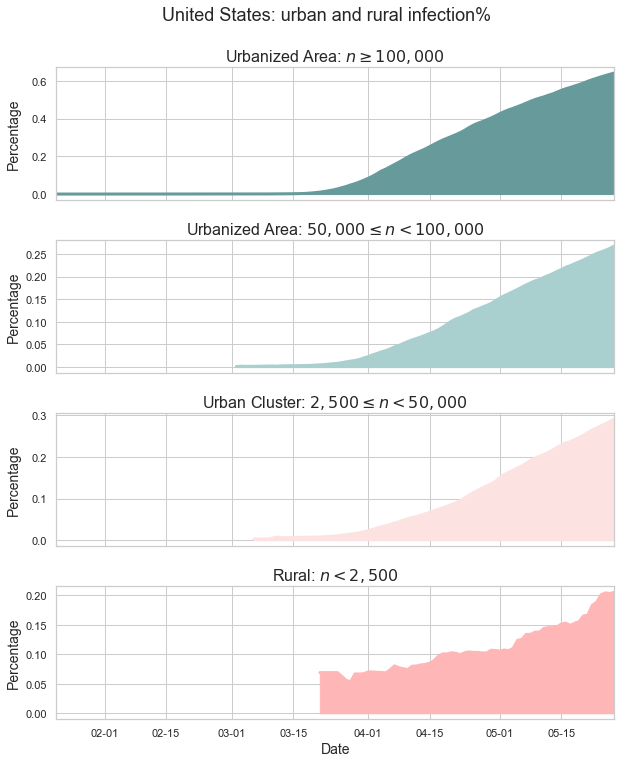

In [12]:
# % stands for percentage
figure_ur(data_county, 'conf', fsize = (10,12), fs = 16, title = 'United States', country = 'US')
figure_ur(data_county, 'conf%', fsize = (10,12), fs = 16, title = 'United States', country = 'US')

In [13]:
# Oversea territories
names_state_more = sorted(set(data_state['state_name']))
# American Samoa is an unincorporated territory of the United States located in the South Pacific Ocean.
# Guam is a U.S. island territory in Micronesia, in the Western Pacific. 
# Puerto Rico is a Caribbean island and unincorporated U.S. territory.
# The U.S. Virgin Islands are a group of Caribbean islands and islets.
# The Northern Mariana Islands are a U.S. commonwealth in the Pacific Ocean.
names_others = [item for item in names_state_more if item not in names_state]

In [14]:
data_state[(data_state['update_date'] == max(data_state['update_date'])) & (data_state['state_name'].isin(names_others))]

,update_date,state_name,fips,cum_confirmed,cum_dead,new_confirmed,new_dead
4700,2020-05-27,Guam,66,1140,6,1.0,0.0
4725,2020-05-27,Northern Mariana Islands,69,22,2,0.0,0.0
4730,2020-05-27,Puerto Rico,72,3397,129,73.0,0.0
4738,2020-05-27,Virgin Islands,78,69,6,0.0,0.0


In [15]:
data_state[data_state['state_name'] == 'New Hampshire']['cum_confirmed'].values[-1]

4286

In [16]:
# Plot the confirmed cases for every state
def figure_conf_all(df, names_state, col, fsize = (5,3), ncol = 4, ms = 2, fs = 10, logy = False, 
                    title = None, country = 'US', pvi = False):
    
    sns.set_style("ticks")
    palette = plt.get_cmap('magma')
    
    m = len(names_state)
    
    fig, axes = plt.subplots(int(np.ceil(m/ncol)), ncol, figsize = (2*fsize[0], int(np.ceil(m/ncol))*fsize[1]), sharey = False)
    fig.subplots_adjust(hspace = 0.4, wspace = 0.2)
    
    if m%ncol != 0:
        for j in range(m, int(np.ceil(m/ncol)*ncol)):
            fig.delaxes(axes.flatten()[j])
            
    for i, state in enumerate(names_state):
        
        if pvi == True:
            c = color_pvi(df_state_pvi, state)
        else:
            c = palette(i/100 + 0.2)
        
        ix = np.unravel_index(i, axes.shape)
        
        plot_df = df[df['state_name'] == state]
        
        axes[ix].plot(plot_df['update_date'], plot_df[col],
                linewidth = 2, marker = 'o', ms = ms, color = c, label = (lambda x: None if x > 0 else col)(i)) # 
        
        if i >= (np.ceil(m/ncol) - 1)*ncol:
            axes[ix].set_xlabel('Date', fontsize = fs - 2)
            
        if i % ncol == 0:
            axes[ix].set_ylabel('Number (cum)', fontsize = fs - 2)
        if i == 0:
            axes[ix].legend(loc = 'upper left', fancybox = True, fontsize = fs - 4)
        axes[ix].set_title(state + ': ' + str(plot_df[col].values[-1]), fontsize = fs)
        
    fig.align_ylabels(axes[:, 0])
    new_dict = {'cum_confirmed': 'new_confirmed', 'cum_dead': 'new_dead'}
    
    for i, state in enumerate(names_state):   
        if pvi == True:
            c = color_pvi(df_state_pvi, state)
        else:
            c = palette(i/100 + 0.2)
        ix = np.unravel_index(i, axes.shape)
        plot_df = df[df['state_name'] == state]
        ax11 = axes[ix].twinx()
        
        ax11.grid(False) # hide grid lines
        ax11.bar(plot_df['update_date'], height = plot_df[new_dict[col]], width = 0.5, linewidth = 0, color = c, alpha = 0.8,
                label = (lambda x: None if x > 0 else new_dict[col])(i))
        daily_patch = mpatches.Patch(color = c, label = new_dict[col])
        if i == 0:
            ax11.legend(handles=[daily_patch], loc='upper left', bbox_to_anchor=(0, 0.86), fancybox=True, fontsize = fs - 4)
        ax11.tick_params(axis = 'both', which = 'major', labelsize = fs - 4)
        ax11.tick_params(axis = 'both', which = 'minor', labelsize = fs - 4)
        
        if i % ncol == ncol - 1:
            ax11.set_ylabel('Number (new)', fontsize = fs - 2)
        
        axes[ix].set_xlim(min(df.update_date), max(df.update_date))
        #axes[ix].xaxis.set_major_locator(mdates.DayLocator((1,15)))
        axes[ix].xaxis.set_major_locator(mdates.MonthLocator())
        axes[ix].xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
        axes[ix].tick_params(axis = 'both', which = 'major', labelsize = fs - 4)
        axes[ix].tick_params(axis = 'both', which = 'minor', labelsize = fs - 4)
        
    fig.suptitle(title, fontsize = fs + 4, y = 0.915)
    
    if pvi == True:
        
        ix = np.unravel_index(int(ncol/2), axes.shape)
        palette_D = plt.get_cmap('Blues')
        palette_R = plt.get_cmap('Reds')
        palette_Even = plt.get_cmap('Greens')
        palette_None = plt.get_cmap('Purples')
        patch_D = mpatches.Patch(color = palette_D(0.6), label = 'Democratic')
        patch_R = mpatches.Patch(color = palette_R(0.6), label = 'Republican')
        patch_Even = mpatches.Patch(color = palette_Even(0.6), label = 'Even')
        patch_None = mpatches.Patch(color = palette_None(0.6), label = 'None')

        axes[ix].legend(handles = [patch_D, patch_R, patch_Even], loc = 'upper left', 
                   ncol = 4, bbox_to_anchor=(-0.65, 1.55), fontsize = fs, fancybox=True)
    
    file_dict = {'cum_confirmed': 'conf', 'cum_dead': 'death'}
    fig.savefig(_Figure_PATH_ + 'figures_us/' + country + '_' + file_dict[col] + '.png', dpi = 400, bbox_inches='tight')

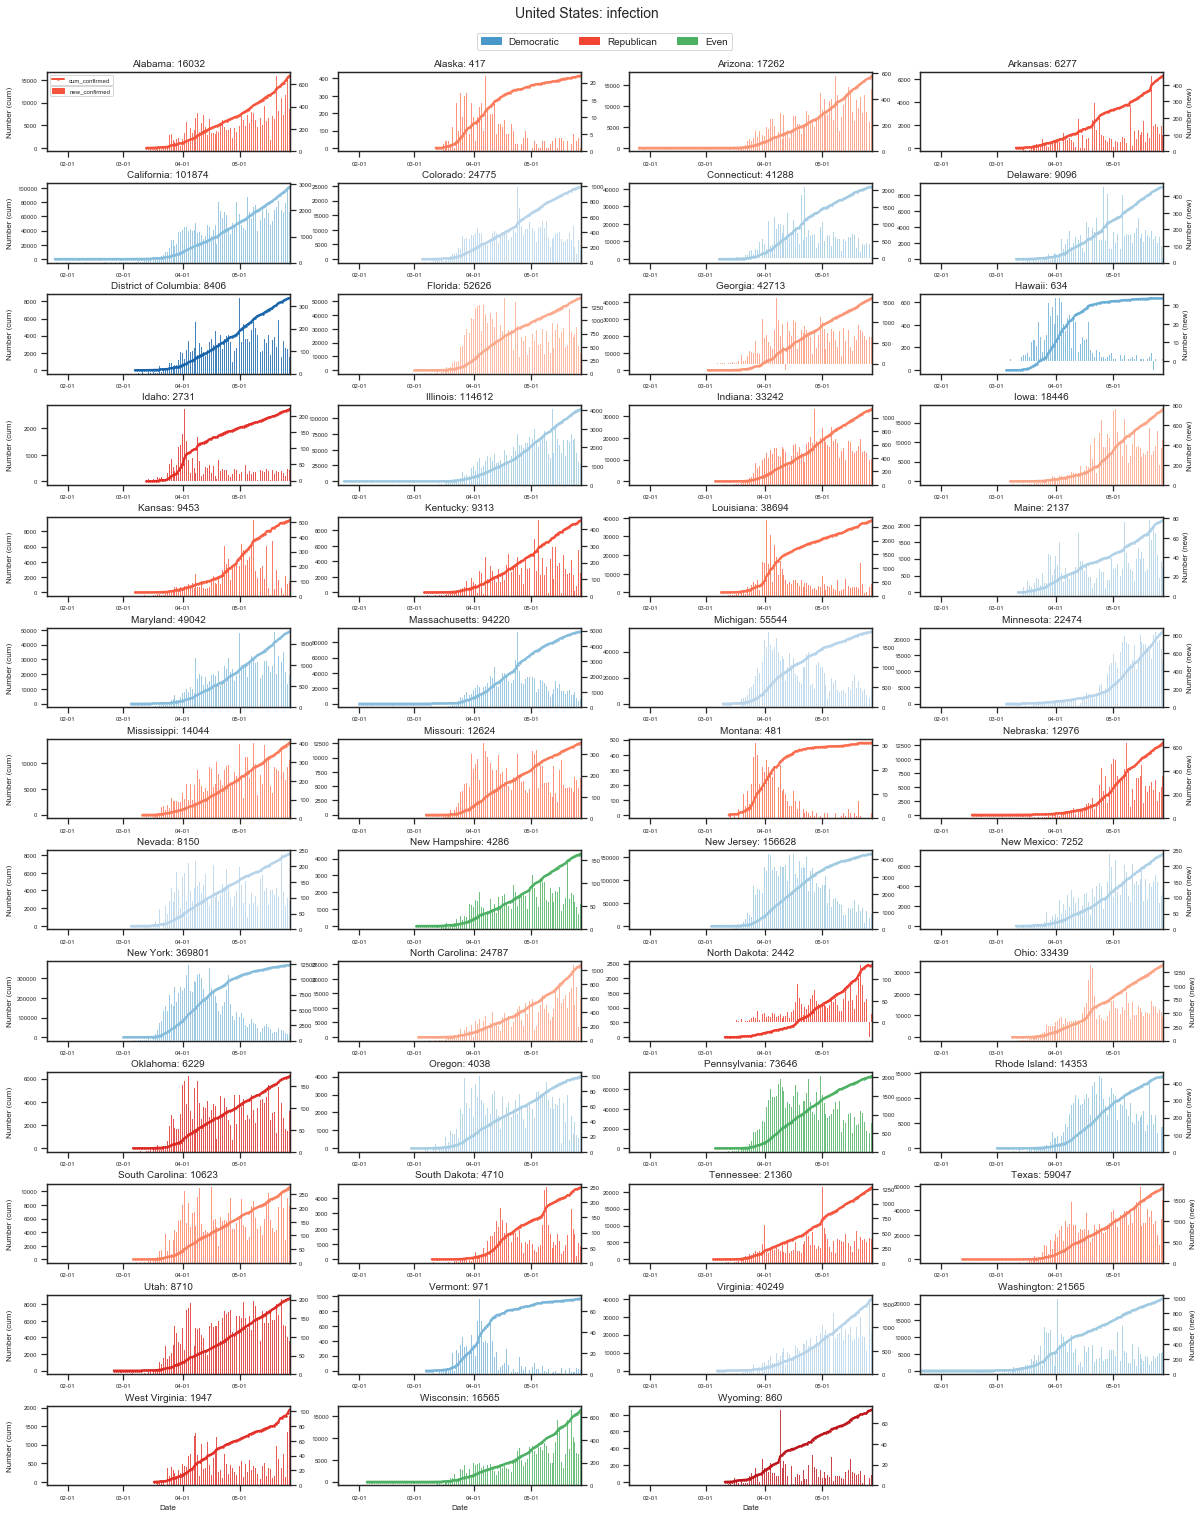

In [17]:
# The problem has to do with aliasing as the bars are too thin to really be separated. 
# Depending on the subpixel value where a bar starts, the white space will be visible or not. 
# The dpi of the plot can either be set for the displayed figure or when saving the image. 
# However, if you have too many bars increasing the dpi will only help a little.
figure_conf_all(df = data_state, names_state = names_state, col = 'cum_confirmed', fsize = (10, 2), ncol = 4, ms = 1.5, fs = 10, logy = False, 
                title = 'United States: infection', country = 'US', pvi = True)

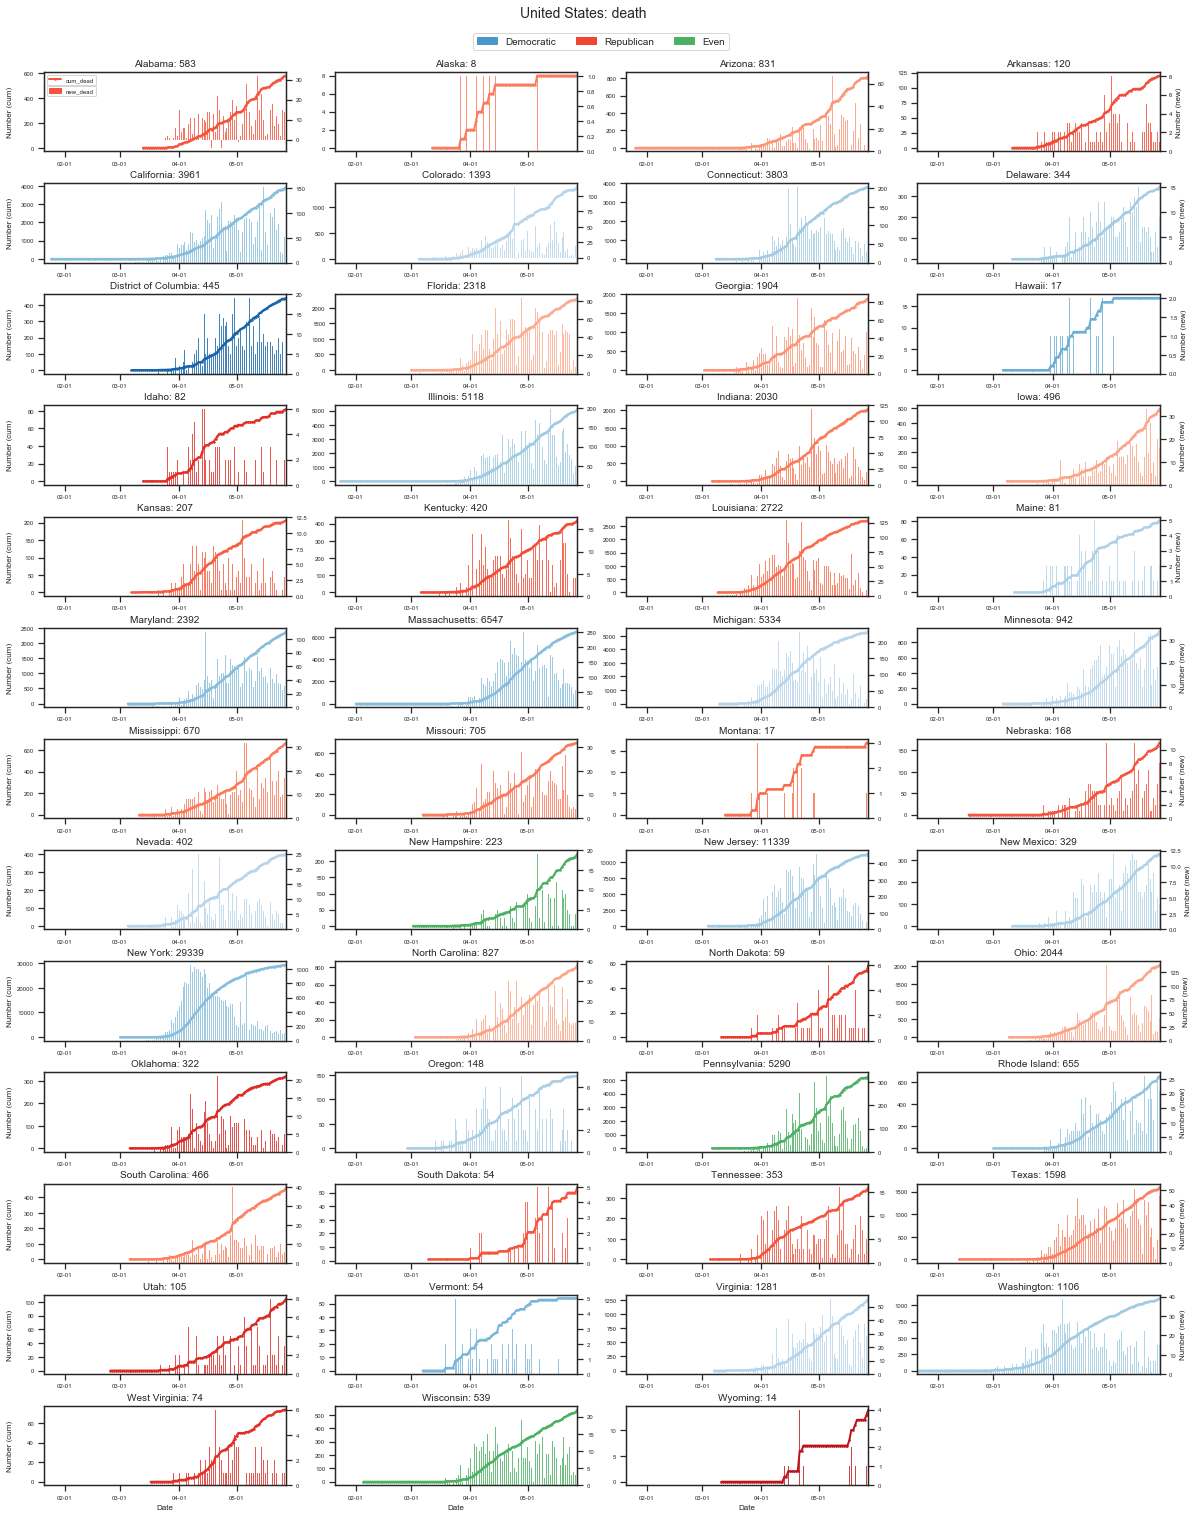

In [18]:
figure_conf_all(df = data_state, names_state = names_state, col = 'cum_dead', fsize = (10, 2), ncol = 4, ms = 1.5, fs = 10, logy = False, 
                title = 'United States: death', country = 'US', pvi = True)

In [19]:
# State level map as html file
def figure_map_html(df, update_date_tr, col, title = None, country = 'US', cmap = 'Tealrose'):
    df = df.copy()
    df = df[df['state_name'].isin(names_state)]
    data_single = df[df['update_date'] == update_date_tr]
    locations = [names_state_short_dict[name] for name in names_state]
    values = [data_single[data_single['state_name'] == item][col].tolist()[0] for item in names_state]
    values_log = [np.log10(temp) for temp in values]
    name_dict = {'cum_confirmed': 'Infection number', 'cum_dead': 'Death'}
    file_dict = {'cum_confirmed': '', 'cum_dead': '_death'}
    fig = go.Figure(data = go.Choropleth(
        locations = locations, # Spatial coordinates
        z = values_log, # Data to be color-coded
        locationmode = 'USA-states', # set of locations match entries in `locations`
        colorscale = cmap,
        marker_line_color = 'white',
        colorbar_title = "number",
        colorbar = dict(
        tickvals = [0, 1, 2, 3, 4, 5, 6],
        ticktext = ["1", "10", "100", "1k", "10k", "100k", "1m"],
        thickness = 15,
        len = 0.8,
        yanchor = "top", 
        x = 0.95,
        y = 0.9,),
        hoverinfo = 'location+text',
        text = values,
    ))

    fig.update_layout(
        title_text = title + '  ' + update_date_tr.strftime("%d %B, %Y") + 
        '<br>' + name_dict[col] + ': ' + str(np.sum(values)),  
        title = dict(x = 0.5, y = 0.85),
        width = 450, 
        height = 300,
        font = dict(
        size = 10,),
        margin = dict(l = 10, r = 10, t = 50, b = 10),
        geo = dict(
            scope = 'usa',
            projection = go.layout.geo.Projection(type = 'albers usa'),
            showlakes = True, # lakes
            lakecolor='rgb(255, 255, 255)'),
    )
    #fig.show()
    fig.write_html(_Figure_PATH_  + 'figures_us/' + country + '_map' + file_dict[col] + '.html')
    return fig

In [20]:
date_tr = max(data_state['update_date'])
fig = figure_map_html(data_state, date_tr, 'cum_confirmed', title = 'United States', country = 'US', cmap = 'Tealrose')
fig = figure_map_html(data_state, date_tr, 'cum_dead', title = 'United States', country = 'US', cmap = 'Earth_r')

In [21]:
# State level map as png file
def figure_map_png(df, update_date_tr, col, title = None, country = 'US', cmap = 'Tealrose'):
    df = df.copy()
    df = df[df['state_name'].isin(names_state)]
    data_single = df[df['update_date'] == update_date_tr]
    locations = [names_state_short_dict[name] for name in names_state]
    values = [data_single[data_single['state_name'] == item][col].tolist()[0] for item in names_state]
    values_log = [np.log10(temp) for temp in values]
    name_dict = {'cum_confirmed': 'Infection number', 'cum_dead': 'Death'}
    file_dict = {'cum_confirmed': '', 'cum_dead': '_death'}
    fig = go.Figure(data = go.Choropleth(
        locations = locations, # Spatial coordinates
        z = values_log, # Data to be color-coded
        locationmode = 'USA-states', # set of locations match entries in `locations`
        colorscale = cmap,
        marker_line_color = 'white',
        colorbar_title = "number",
        colorbar = dict(
        tickvals = [0, 1, 2, 3, 4, 5, 6],
        ticktext = ["1", "10", "100", "1k", "10k", "100k", "1m"],
        thickness = 40),
        hoverinfo = 'location+text',
        text = values,
    ))

    fig.update_layout(
        title_text = title + '  ' + update_date_tr.strftime("%d %B, %Y") + 
        '<br>' + name_dict[col] + ': ' + str(np.sum(values)),
        title = dict(x = 0.5, y = 0.95),
        width = 1800, 
        height = 1050,
        font = dict(
        size = 30,),
        geo = dict(
            scope = 'usa',
            projection = go.layout.geo.Projection(type = 'albers usa'),
            showlakes = True, # lakes
            lakecolor='rgb(255, 255, 255)'),
    )
    fig.write_image(_Figure_PATH_ + 'figures_us/' + country + '_map' + file_dict[col] + '.png')
    return fig

In [22]:
#/Users/xingruchen/anaconda3/bin/orca serve -p 54030 --plotly 
#/Users/xingruchen/anaconda3/lib/python3.7/site-packages/plotly/package_data/plotly.min.js --graph-only --mathjax https://cdnjs.cloudflare.com/ajax/libs/mathjax/2.7.5/MathJax.js
fig = figure_map_png(data_state, date_tr, 'cum_confirmed', title = 'United States', country = 'US', cmap = 'Tealrose')
fig = figure_map_png(data_state, date_tr, 'cum_dead', title = 'United States', country = 'US', cmap = 'Earth_r')

In [23]:
# A very comprehensive rose figure
def figure_conf_rose(df, names_state, update_date_tr, col, title = 'United States', country = 'US', percentage = False):

    df = df.copy()
    df = df[df['update_date'] == update_date_tr]
    df = df[df['state_name'].isin(names_state)]

    bars = [df[df['state_name'] == state][col].tolist()[0] for state in names_state]

    df = pd.DataFrame({'state_name': names_state, 'value': bars})
    df.sort_values(by = 'value', ascending = False, inplace = True)

    v = df['state_name'].values.tolist()
    d = df['value'].values.tolist()

    d_D = [d[i] for i, name in enumerate(v) if df_state_pvi[df_state_pvi['state_name'] == name]['partisan'].tolist()[0] == 'D']
    d_R = [d[i] for i, name in enumerate(v) if df_state_pvi[df_state_pvi['state_name'] == name]['partisan'].tolist()[0] == 'R']
    d_Even = [d[i] for i, name in enumerate(v) if df_state_pvi[df_state_pvi['state_name'] == name]['partisan'].tolist()[0] == 'Even']
    d_None = [d[i] for i, name in enumerate(v) if df_state_pvi[df_state_pvi['state_name'] == name]['partisan'].tolist()[0] == 'None']

    palette_D = plt.get_cmap('Blues')
    palette_R = plt.get_cmap('Reds')
    palette_Even = plt.get_cmap('Greens')

    color_series_inner = [rgb2hex(palette_D(0.6)), rgb2hex(palette_R(0.6)), rgb2hex(palette_Even(0.6))]
    color_series = color_series_inner + [rgb2hex(color_pvi(df_state_pvi, state)) for state in v]

    inner_x_data = ['Democratic', 'Republican', 'Even']
    inner_y_data = [np.sum(d_D), np.sum(d_R), np.sum(d_Even)]
    inner_x_data = [item + ': ' + str(inner_y_data[i]) for i, item in enumerate(inner_x_data)]
    inner_y_data = [round(item*100/np.sum(d), 2) for item in inner_y_data]
    inner_data_pair = [list(z) for z in zip(inner_x_data, inner_y_data)]

    v = [names_state_short_dict[item] for item in v]

    v = [item + ': ' + str(d[i]) for i, item in enumerate(v)]

    #d = [round(np.sqrt(temp),2) for temp in d] ######## rescale data by taking the square root ########

    pie = Pie(init_opts = opts.InitOpts(width='460px', height='850px'))

    pie.set_colors(color_series)

    fn = """
        function(params) {
            if(params.name.includes('Republican'))
                return '\\n\\n\\n' + params.name.substring(0, 10) + ' : ' + params.value + '%';
            if(params.name.includes('Even'))
                return '\\n\\n\\n\\n\\n\\n' + params.name.substring(0, 4) + ' : ' + params.value + '%';
            if(params.name.includes('None'))
                return '\\n\\n\\n\\n\\n\\n\\n\\n\\n' + params.name.substring(0, 4) + ' : ' + params.value + '%';
            return params.name.substring(0, 10) + ' : ' + params.value + '%';
        }
        """
    def new_label_opts():
        return opts.LabelOpts(formatter = JsCode(fn), font_size = 12, font_weight = 'bold', 
                              position = "center", vertical_align = 'top')
    pie.add(
            series_name = "national",
            data_pair = inner_data_pair,
            radius = ["35%", "45%"], # radius=["50%", "70%"],
            center = ["58%", "77%"],
            label_opts = new_label_opts(),
        )

    fn = """
        function(params) {
            return params.name.substring(0, 2);
        }
        """
    def new_label_opts():
        return opts.LabelOpts(formatter = JsCode(fn), font_size = 10, font_weight = 'bold',
                              position = "inside", vertical_align = 'bottom')
    pie.add("state", [list(z) for z in zip(v, d)],
            radius = ["65%", "255%"], # radius = ["80%", "110%"],
            center = ["58%", "77%"],
            rosetype = "area",
            label_opts = new_label_opts(), # is_show = True, rotate = 'tangent',
            )

    pie.set_global_opts(title_opts = opts.TitleOpts(title = title,subtitle = update_date_tr.strftime("%d %B, %Y"),
                                                title_textstyle_opts = opts.TextStyleOpts(font_size = 20),
                                                subtitle_textstyle_opts = opts.TextStyleOpts(font_size = 18)),
                        legend_opts = opts.LegendOpts(is_show = True, type_ = "plain", item_width = 20, item_height = 10,
                                                      textstyle_opts = opts.TextStyleOpts(font_size = 10), 
                                                      pos_top = "8%", pos_left = "1%", orient = "vertical"),
                        tooltip_opts = opts.TooltipOpts(formatter = '{b}'))

    file_dict = {'cum_confirmed': '', 'cum_dead': '_death'}
    make_snapshot(snapshot, pie.render(_Figure_PATH_ + 'figures_us/' + country + "_rose" + file_dict[col] + ".html"),
                              _Figure_PATH_ + 'figures_us/' + country + "_rose" + file_dict[col] + ".png")

In [24]:
# chromedriver in /usr/local/bin/
date_tr = max(data_state['update_date'])
figure_conf_rose(data_state, names_state, date_tr, 'cum_confirmed',
                title = "United States: infection", country = 'US', percentage = False)

In [25]:
figure_conf_rose(data_state, names_state, date_tr, 'cum_dead',
                title = "United States: death", country = 'US', percentage = False)

In [26]:
# Plot the confirmed cases for every county in a given state
def figure_conf_state(df, fsize = (5, 3), ncol = 4, ms = 2, fs = 10, logy = False, 
                      title = None, country = 'US', state = 'New Hampshire', cmap = 'viridis'):
    
    sns.set_style("ticks")
    palette = plt.get_cmap(cmap)
    palette = ['#AEDADE', '#F9F6D3', '#F5D1BE', '#EAA2A4', '#E385A9','#BA77B4'] # adaptive and live
    palette = ['#009392', '#72aaa1', '#b1c7b3', '#e5b9ad', '#d98994', '#d0587e'] # tealrose
    palette = ['#009B9E', '#42B7B9', '#A7D3D4', '#E4C1D9', '#D691C1', '#C75DAB'] # tropic
    palette = ['#798234', '#a3ad62', '#d0d3a2', '#f0c6c3', '#df91a3', '#d46780'] # armyrose
    palette = ['#008080', '#70a494', '#b4c8a8', '#edbb8a', '#de8a5a', '#ca562c'] # geyser
    palette = ['#009392', '#39b185', '#9ccb86', '#eeb479', '#e88471', '#cf597e'] # temps
    palette = ['#3d5941', '#778868', '#b5b991', '#edbb8a', '#de8a5a', '#ca562c'] # fall
    palette = ['#72aaa1', '#b1c7b3', '#f1eac8', '#e5b9ad', '#d98994', '#d0587e'] # tealrose (1-6)
    
    df_with = df[df['state_name'] == state].copy()
    df = df[df['state_name'] == state].copy()
    df = df[df['county_name']!='Unknown']
    df = df.reset_index(drop=True)
    names_county = sorted(set(df['county_name']))
    m = len(names_county)
    
    df_rank = df[df['update_date'] == max(df['update_date'])]
    df_rank = df_rank.reset_index(drop=True)
    df_rank = df_rank.sort_values(by = 'cum_confirmed')
    rank_list = df_rank.index.tolist()
    
    fig, axes = plt.subplots(int(np.ceil(m/ncol)), ncol, figsize = (2*fsize[0], int(np.ceil(m/ncol))*fsize[1]), sharey = False)
    fig.subplots_adjust(hspace = 0.4, wspace = 0.2)
    
    if m%ncol != 0:
        for j in range(m, int(np.ceil(m/ncol)*ncol)):
            fig.delaxes(axes.flatten()[j])
    
    
    for i, county in enumerate(names_county):
        
        ix = np.unravel_index(i, axes.shape)
        
        plot_df = df[df['county_name'] == county]
        plot_df = plot_df.reset_index(drop=True)
        
        c = palette[int(rank_list.index(i)/m*len(palette))]
        axes[ix].plot(plot_df['update_date'], plot_df['cum_confirmed'], 
                      linewidth = 2, marker = 'o', ms = ms, alpha = 0.8,
                      color = c, label = (lambda x: None if x > 0 else 'cum_confirmed')(i)) # 
        if i >= (np.ceil(m/ncol) - 1)*ncol:
            axes[ix].set_xlabel("Date", fontsize = fs - 2)
        if i % ncol == 0:
            axes[ix].set_ylabel("Number (cum)", fontsize = fs - 2)
        if i == 0:
            axes[ix].legend(loc = 'upper left', fancybox = True, fontsize = fs - 2)
        axes[ix].set_title(county + ': ' + str(plot_df['cum_confirmed'].tolist()[-1]), fontsize = fs)
        
    fig.align_ylabels(axes[:, 0])    
    
    for i, county in enumerate(names_county):   
        ix = np.unravel_index(i, axes.shape)
        plot_df = df[df['county_name'] == county].groupby('update_date').agg('sum')
        #if i not in empty_list:
        ax11 = axes[ix].twinx()
        ax11.grid(False) # hide grid lines
        c = palette[int(rank_list.index(i)/m*len(palette))]
        ax11.bar(x = plot_df.index, height = plot_df['new_confirmed'],
                 color = c, alpha = 0.8,
                 label = (lambda x: None if x > 0 else 'new_confirmed')(i))
        daily_patch = mpatches.Patch(color = c, label='new_confirmed')
        if i == 0:
            ax11.legend(handles=[daily_patch], loc='upper left', bbox_to_anchor=(0, 0.86), fancybox=True, fontsize = fs - 2)
        if i % ncol == ncol - 1:
            ax11.set_ylabel('Number (new)', fontsize = fs - 2)
        ax11.tick_params(axis = 'both', which = 'major', labelsize = fs - 4)
        ax11.tick_params(axis = 'both', which = 'minor', labelsize = fs - 4)

        axes[ix].set_xlim(min(df.update_date), max(df.update_date))
        axes[ix].xaxis.set_major_locator(mdates.DayLocator((1,15)))
        axes[ix].xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
        axes[ix].tick_params(axis = 'both', which = 'major', labelsize = fs - 4)
        axes[ix].tick_params(axis = 'both', which = 'minor', labelsize = fs - 4)
        
    df_with = df_with.groupby(['update_date'])['cum_confirmed'].apply(lambda x : x.sum()).reset_index()       
    fig.suptitle(title + ': ' + str(df_with['cum_confirmed'].tolist()[-1]), fontsize = fs + 2, y = 0.93)
    
    
    fig.savefig(_Figure_PATH_ + 'figures_us_be/' + country + '_' + state.replace(" ", "_") + '_conf.png', dpi = 400, bbox_inches='tight')

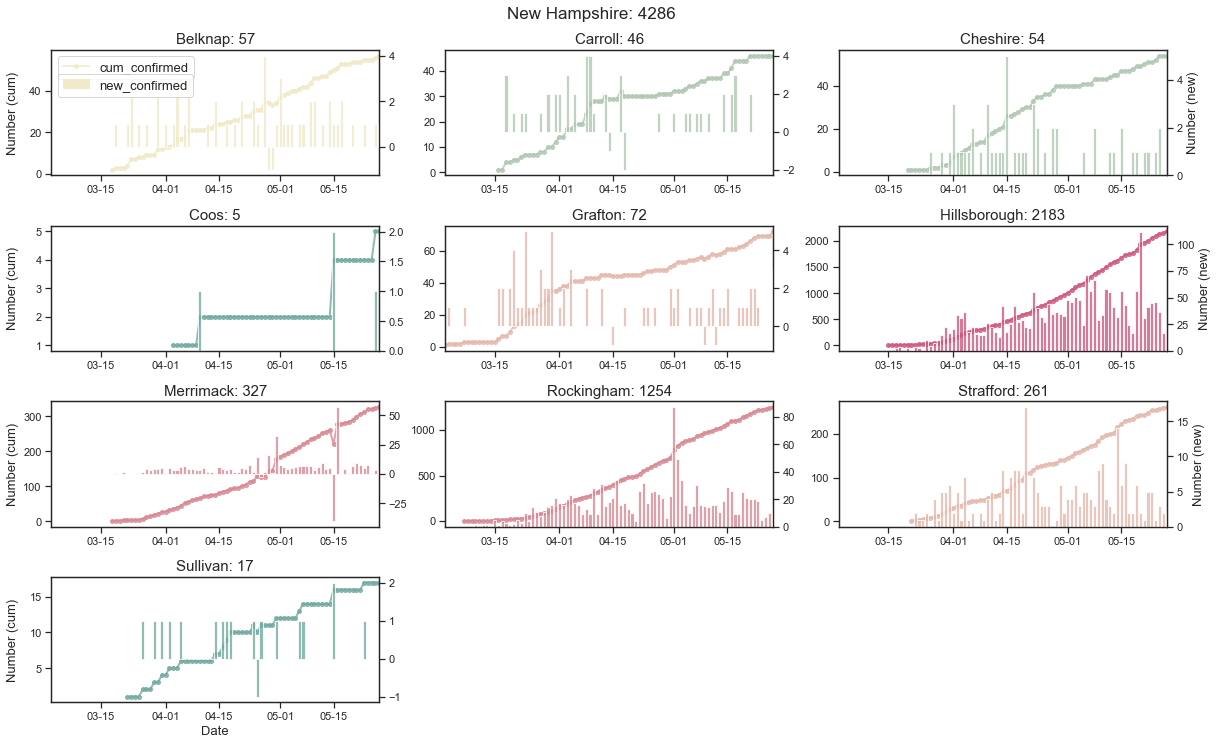

In [27]:
# Our home: Dartmouth College \in Hanover \in Grafton \in New Hampshire
state = 'New Hampshire'
figure_conf_state(df = data_county, fsize = (10, 3), ncol = 3, ms = 4, fs = 15, logy = False, 
                      title = state, country = 'US', state = state, cmap = 'bone')

In [28]:
# plot the confirmed cases for the top 6 counties of every state in a given area
def figure_conf_state_all(df, names_state, fsize = (10,5), ncol = 2, ms = 6, fs = 18, logy = False, 
                    title = None, country = 'US'):
    
    sns.set_style("ticks")
    palette = ['#72aaa1', '#b1c7b3', '#f1eac8', '#e5b9ad', '#d98994', '#d0587e'] # tealrose (1-6)
    
    m = len(names_state)
    
    fig, axes = plt.subplots(int(np.ceil(m/ncol)), ncol, figsize = (2*fsize[0], int(np.ceil(m/ncol))*fsize[1]), sharey = False)
    fig.subplots_adjust(hspace = 0.4, wspace = 0.2)
    
    if m%ncol != 0:
        for j in range(m, int(np.ceil(m/ncol)*ncol)):
            fig.delaxes(axes.flatten()[j])
    palette.reverse()       
    for i, state in enumerate(names_state):
        
        ix = np.unravel_index(i, axes.shape)
        
        plot_df = df[df['state_name'] == state]
        plot_df = plot_df.reset_index(drop = True)
        
        data_single = df[(df['state_name'] == state) & (df['update_date'] == max(df['update_date']))]
        # the 6 counties with the highest numbers of infected 
        county_selected = data_single[data_single['county_name']!= 'Unknown'].sort_values(by = 'cum_confirmed')['county_name'].tail(6).tolist()                                                       
        county_selected.reverse() 
        
        for j, name in enumerate(county_selected):
            
            c = palette[j]
            plot_df_single = plot_df[plot_df['county_name'] == name]
            axes[ix].plot(plot_df_single['update_date'], plot_df_single['cum_confirmed'],
                    linewidth = 3, marker = 'o', ms = ms, color = c, alpha = 0.8, label = name) 
            
        if i >= (np.ceil(m/ncol) - 1)*ncol:
            axes[ix].set_xlabel('Date', fontsize = fs - 2)
            
        if i % ncol == 0:
            axes[ix].set_ylabel('Number', fontsize = fs - 2)
        
        handles, labels = axes[ix].get_legend_handles_labels()
        
        def flip(items, ncol):
            return itertools.chain(*[items[i::ncol] for i in range(ncol)])
        
        axes[ix].legend(flip(handles, 3), flip(labels, 3), loc='upper center', ncol = 3, fancybox=True, fontsize = fs - 4)
        
    
        axes[ix].set_title(state + ': ' + str(np.sum(data_single['cum_confirmed'])), fontsize = fs)
        axes[ix].set_xlim(min(df[df['state_name'].isin(names_state)].update_date), max(df[df['state_name'].isin(names_state)].update_date))
        axes[ix].xaxis.set_major_locator(mdates.DayLocator((1,15)))
        axes[ix].xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
        axes[ix].tick_params(axis = 'both', which = 'major', labelsize = fs - 4)
        axes[ix].tick_params(axis = 'both', which = 'minor', labelsize = fs - 4)
        
    fig.align_ylabels(axes[:, 0])
    fig.suptitle(title, fontsize = fs + 4, y = 0.94)

    fig.savefig(_Figure_PATH_ + 'figures_us_be/' + country + '_new_england_conf.png', dpi = 400, bbox_inches='tight')

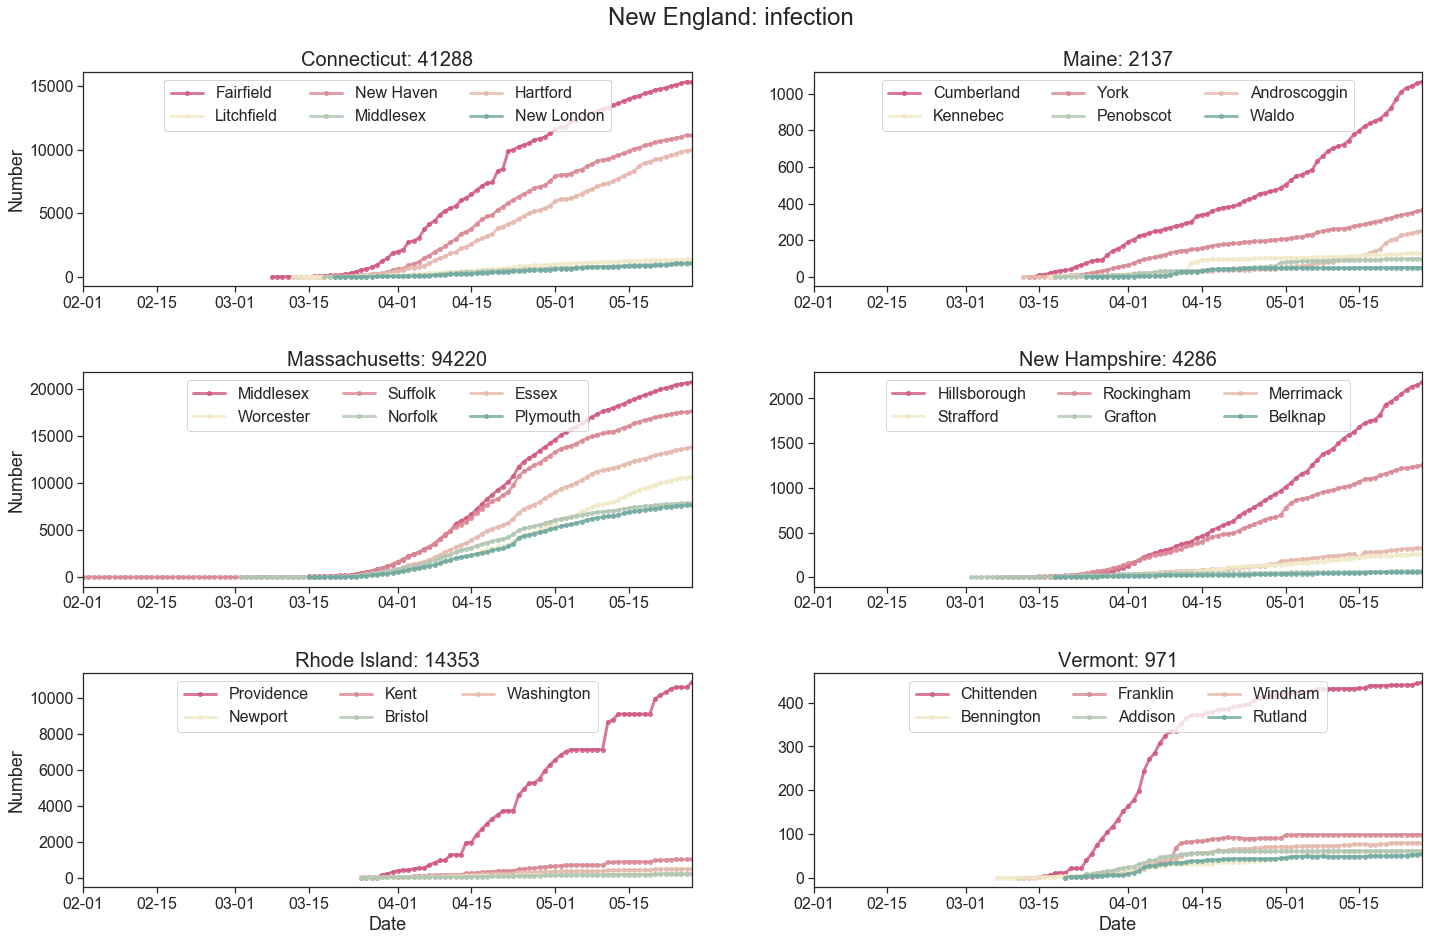

In [29]:
names_state_selected = ['Connecticut', 'Maine', 'Massachusetts', 'New Hampshire', 'Rhode Island', 'Vermont']
figure_conf_state_all(data_county, names_state_selected, fsize = (12,5), ncol = 2, ms = 4, fs = 20, logy = False, 
                    title = 'New England: infection', country = 'US')

In [30]:
# County level map
def figure_map_state_html(df, update_date_tr, col, title = None, country = 'US', cmap = 'viridis'):
    
    with urlopen('https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json') as response:
        counties = json.load(response)
    
    df = df.copy()
    #df.at[df.index[df['county_name'] == 'Kansas City'].tolist(), 'fips'] = 293800
    df.at[df.index[data_county['county_name'] == 'New York City'].tolist(), 'fips'] = 36061
    df = df[df['county_name']!='Unknown'].copy()
    df = df[df['state_name'].isin(names_state)]
    data_single = df[df['update_date'] == update_date_tr]
    # deal with fips
    data_single['fips'] = data_single['fips'].astype('str')
    data_single['fips'] = data_single['fips'].apply(lambda x: x[:-2]).apply(lambda x: x.zfill(5)) # remove '.0'
    # remove rows with nonexisting fips
    data_single = data_single[data_single['fips'].isin([item['id'] for item in counties['features']])]
    # log scale
    data_single[col + '_log'] = data_single[col].apply(lambda x: np.log10(x))
    # add missing counties
    for item in counties['features']:
        if item['id'] not in data_single['fips'].tolist():
            new_row = {'update_date': update_date_tr, 
                       'county_name': item['properties']['NAME'], 'state_name': item['properties']['STATE'], 
                       'fips': item['id'], 
                       'cum_confirmed': np.nan, 'cum_dead': np.nan, 'new_confirmed': np.nan, 'new_dead': np.nan, 'cum_confirmed_log': np.nan}
            data_single = data_single.append(new_row, ignore_index = True)
    name_dict = {'cum_confirmed': 'Infection', 'cum_dead': 'Death'}
    hover_dict = {'cum_confirmed': 'Infection number', 'cum_dead': 'Death'}
    file_dict = {'cum_confirmed': '', 'cum_dead': '_death'}
    fig = px.choropleth(data_single, geojson = counties, locations = 'fips', color = col + '_log',
                        color_continuous_scale = cmap, 
                        hover_name = 'county_name',
                        hover_data = {'state_name': True, col: True, col + '_log': False},
                        scope = "usa",
                        custom_data = [col],
                       )
    fig.layout.template = None
    fig.update_layout(
        title_text = title + '  ' + update_date_tr.strftime("%d %B, %Y") + '  ' + name_dict[col],
        title = dict(x = 0.5, y = 0.95),
        width = 900, 
        height = 500,
        font = dict(
        size = 15,),
        coloraxis_colorbar = dict(
            title = "number",
            tickvals = [0, 1, 2, 3, 4, 5],
            ticktext = ["1", "10", "100", "1k", "10k", "100k"],
            thickness = 20,
            len = 0.8,
            yanchor = "top", 
            x = 0.95,
            y = 0.9,
            outlinecolor = 'white'),
        margin = dict(l = 0, r = 10, t = 10, b = 10),
        geo = dict(
            scope = 'usa',
            projection = go.layout.geo.Projection(type = 'albers usa'),
            showlakes = True, # lakes
            lakecolor = 'rgb(255, 255, 255)'),
    )
    #print("plotly express hovertemplate:", fig.data[0].hovertemplate)
    fig.update_traces(hovertemplate = '<b>%{hovertext}, %{customdata[1]}</b><br>' + hover_dict[col] + ': %{customdata[0]}<extra></extra>')
    fig.update_traces(marker = dict(line = dict(width = 0.2, color = 'black')),)
    fig.write_html(_Figure_PATH_ + 'figures_us_be/' + country + '_map_state' + file_dict[col] + '.html')

In [31]:
date_tr = max(data_state['update_date'])
figure_map_state_html(data_county, date_tr, 'cum_confirmed', title = 'United States', country = 'US', cmap = 'Tealrose')
figure_map_state_html(data_county, date_tr, 'cum_dead', title = 'United States', country = 'US', cmap = 'Earth_r')

In [32]:
# County level map
def figure_map_state_png(df, update_date_tr, col, title = None, country = 'US', cmap = 'viridis'):
    
    with urlopen('https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json') as response:
        counties = json.load(response)
    
    df = df.copy()
    #df.at[df.index[df['county_name'] == 'Kansas City'].tolist(), 'fips'] = 293800
    df.at[df.index[data_county['county_name'] == 'New York City'].tolist(), 'fips'] = 36061
    df = df[df['county_name']!='Unknown'].copy()
    df = df[df['state_name'].isin(names_state)]
    data_single = df[df['update_date'] == update_date_tr]
    # deal with fips
    data_single['fips'] = data_single['fips'].astype('str')
    data_single['fips'] = data_single['fips'].apply(lambda x: x[:-2]).apply(lambda x: x.zfill(5)) # remove '.0'
    # remove rows with nonexisting fips
    data_single = data_single[data_single['fips'].isin([item['id'] for item in counties['features']])]
    # log scale
    data_single[col + '_log'] = data_single[col].apply(lambda x: np.log10(x))
    # add missing counties
    for item in counties['features']:
        if item['id'] not in data_single['fips'].tolist():
            new_row = {'update_date': update_date_tr, 
                       'county_name': item['properties']['NAME'], 'state_name': item['properties']['STATE'], 
                       'fips': item['id'], 
                       'cum_confirmed': np.nan, 'cum_dead': np.nan, 'new_confirmed': np.nan, 'new_dead': np.nan, 'cum_confirmed_log': np.nan}
            data_single = data_single.append(new_row, ignore_index = True)
    name_dict = {'cum_confirmed': 'Infection', 'cum_dead': 'Death'}
    hover_dict = {'cum_confirmed': 'Infection number', 'cum_dead': 'Death'}
    file_dict = {'cum_confirmed': '', 'cum_dead': '_death'}
    fig = px.choropleth(data_single, geojson = counties, locations = 'fips', color = col + '_log',
                        color_continuous_scale = cmap, 
                        hover_name = 'county_name',
                        hover_data = {'state_name': True, col: True, col + '_log': False},
                        scope = "usa",
                        custom_data = [col],
                       )
    fig.layout.template = None
    fig.update_layout(
        title_text = title + '  ' + update_date_tr.strftime("%d %B, %Y") + '  ' + name_dict[col],
        title = dict(x = 0.5, y = 0.95),
        width = 1800, 
        height = 1050,
        font = dict(
        size = 30,),
        coloraxis_colorbar = dict(
            title = "number",
            tickvals = [0, 1, 2, 3, 4, 5],
            ticktext = ["1", "10", "100", "1k", "10k", "100k"],
            thickness = 40,
            len = 0.8,
            yanchor = "top", 
            y = 0.9,
            outlinecolor = 'white'),
        margin = dict(l = 5, r = 20, t = 25, b = 20),
        geo = dict(
            scope = 'usa',
            projection = go.layout.geo.Projection(type = 'albers usa'),
            showlakes = True, # lakes
            lakecolor = 'rgb(255, 255, 255)'),
    )
    fig.update_traces(hovertemplate = '<b>%{hovertext}, %{customdata[1]}</b><br>' + hover_dict[col] + ': %{customdata[0]}<extra></extra>')
    #fig.update_traces(marker = dict(line = dict(width = 0.2, color = 'black')),)
    fig.write_image(_Figure_PATH_ + 'figures_us_be/' + country + '_map_state' + file_dict[col] + '.png')

In [33]:
date_tr = max(data_state['update_date'])
figure_map_state_png(data_county, date_tr, 'cum_confirmed', title = 'United States', country = 'US', cmap = 'Tealrose')
figure_map_state_png(data_county, date_tr, 'cum_dead', title = 'United States', country = 'US', cmap = 'Earth_r')




In [34]:
def figure_SP(df, df_SP, update_date_initial, fsize = (12,5), ms = 6, fs = 16, title = None, country = 'US'):
    
    palette = ['#679b9b', '#aacfcf', '#fde2e2', '#ffb6b6']
    df = df[df['update_date'] >= update_date_initial]
    df = df.reset_index(drop = True)
    df_SP = df_SP[df_SP['update_date'] >= update_date_initial]
    df_SP = df_SP.reset_index(drop = True)
    df_nation = df.groupby(['update_date'])['new_confirmed'].apply(lambda x : x.sum()).reset_index()
    fig = plt.figure(figsize = fsize)
    ax = plt.subplot(111)
    sns.set_style('ticks')
    ax.plot(df_nation['update_date'], df_nation['new_confirmed'], 
            linewidth = 2, marker = 'o', ms = ms, color = palette[0], label = 'COVID-19')
    
    ax.set_xlabel('Date', fontsize = fs - 2)
    ax.set_ylabel('Number of infected (new)', fontsize = fs - 2)
    
    ax.legend(loc = 'upper left', fontsize = fs - 2, bbox_to_anchor=(0.0, 1), fancybox=True)
    
    ax_twin = ax.twinx()
    ax_twin.plot(df_SP['update_date'], df_SP['close'], 
            linewidth = 2, marker = 'o', ms = ms, color = palette[3], label = 'S&P 500')
    
    ax_twin.set_ylabel('Index', fontsize = fs - 2)
    
    ax_twin.legend(loc = 'upper right', fontsize = fs - 2, bbox_to_anchor=(1, 1), fancybox=True)
    #ax_twin.set_ylim(min(df_SP['close']), max(df_SP['close']))
    
    ax.set_xlim(min(df.update_date), max(df.update_date))
    ax.xaxis.set_major_locator(mdates.DayLocator((1,15)))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    
    ax.tick_params(axis = 'both', which = 'major', labelsize = fs - 4)
    ax.tick_params(axis = 'both', which = 'minor', labelsize = fs - 4)

    fig.suptitle('Correlation: infection and the S & P 500 index', fontsize = fs + 2, y = 0.95)
    
    fig.savefig(_Figure_PATH_ + 'figures_us_be/' + country + '_correlation.png', dpi = 400, bbox_inches='tight')

In [35]:
def figure_stock(df, stock_name, title_name, update_date_initial, fsize = (12,5), ms = 6, fs = 16, title = None, country = 'US'):
    
    palette = ['#679b9b', '#aacfcf', '#fde2e2', '#ffb6b6']
    df = df[df['update_date'] >= update_date_initial]
    
    df_nation = df.groupby(['update_date'])['new_confirmed'].apply(lambda x : x.sum()).reset_index()
    fig = plt.figure(figsize = fsize)
    ax = plt.subplot(111)
    sns.set_style('ticks')
    ax.plot(df_nation['update_date'], df_nation['new_confirmed'], 
            linewidth = 2, marker = 'o', ms = ms, color = palette[0], label = 'COVID-19')
    
    ax.set_xlabel('Date', fontsize = fs - 2)
    ax.set_ylabel('Number of infected (new)', fontsize = fs - 2)
    
    ax.legend(loc = 'upper left', fontsize = fs - 2, bbox_to_anchor=(0.0, 1), fancybox=True)
    
    ax_twin = ax.twinx()
    
    data_stock = load_STOCK_raw(stock_name)
    data_stock = data_stock[data_stock['update_date'] >= update_date_initial]
    data_stock = data_stock.reset_index(drop = True)
    ax_twin.plot(data_stock['update_date'], data_stock['close'], 
                 linewidth = 2, marker = 'o', ms = ms, color = palette[3], label = title_name)
    
    ax_twin.set_ylabel('Price', fontsize = fs - 2)
    
    ax_twin.legend(loc = 'upper right', fontsize = fs - 2, bbox_to_anchor=(1, 1), fancybox=True)
    #ax_twin.set_ylim(min(df_SP['close']), max(df_SP['close']))
    
    ax.set_xlim(min(df.update_date), max(df.update_date))
    ax.xaxis.set_major_locator(mdates.DayLocator((1,15)))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    
    ax.tick_params(axis = 'both', which = 'major', labelsize = fs - 4)
    ax.tick_params(axis = 'both', which = 'minor', labelsize = fs - 4)

    fig.suptitle('Correlation: infection and the stock price of ' + title_name, fontsize = fs + 2, y = 0.95)
    
    fig.savefig(_Figure_PATH_ + 'figures_us_be/' + country + '_correlation_' + stock_name + '.png', dpi = 400, bbox_inches='tight')

In [36]:
# S&P 500 index
data_SP = load_SP_raw()

Data date range:  1927-12-30 to 2020-05-28
Number of rows in raw data:  23211


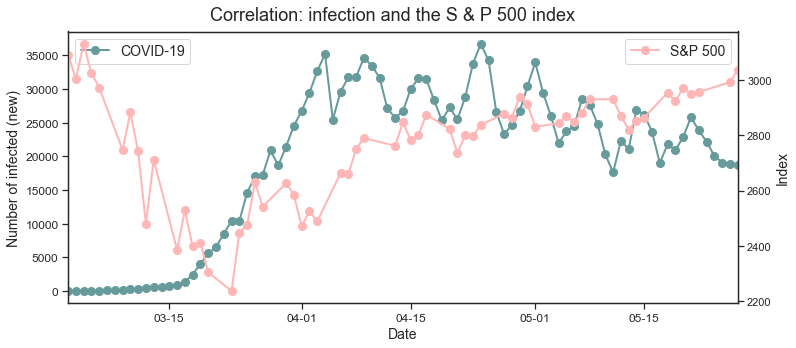

In [37]:
date_initial = datetime.date(int(2020),int(3),int(2))
figure_SP(data_state, data_SP, date_initial, fsize = (12,5), ms = 8, fs = 16, title = 'United State', country = 'US')

In [38]:
#stock_name = 'ZM'
#title_name = 'Zoom'
#figure_stock(data_state, stock_name, title_name, date_initial, fsize = (12,5), ms = 8, fs = 16, title = 'United States', country = 'US')

In [39]:
def figure_stock_list(df, stock_name_list, title_name_list, update_date_initial, 
                      fsize = (12,5), ncol = 2, ms = 6, fs = 16, title = None, country = 'US'):
    
    palette = ['#679b9b', '#aacfcf', '#fde2e2', '#ffb6b6']
    df = df[df['update_date'] >= update_date_initial]
    df = df.reset_index(drop = True)
    
    df_nation = df.groupby(['update_date'])['new_confirmed'].apply(lambda x : x.sum()).reset_index()
    df_nation = df_nation[(df_nation['update_date'] >= min(df.update_date)) & (df_nation['update_date'] <= max(df.update_date))]
    df_nation = df_nation.reset_index(drop = True)
    
    m = len(stock_name_list)
    
    fig, axes = plt.subplots(int(np.ceil(m/ncol)), ncol, figsize = (2*fsize[0], int(np.ceil(m/ncol))*fsize[1]), sharey = False)
    fig.subplots_adjust(hspace = 0.4, wspace = 0.2)
    
    if m%ncol != 0:
        for j in range(m, int(np.ceil(m/ncol)*ncol)):
            fig.delaxes(axes.flatten()[j])
            
    for i, stock_name in enumerate(stock_name_list):
        
        ix = np.unravel_index(i, axes.shape)
        ax = axes[ix]
        ax.plot(df_nation['update_date'], df_nation['new_confirmed'], 
                linewidth = 2, marker = 'o', ms = ms, color = palette[0], label = 'COVID-19')
        if i >= (np.ceil(m/ncol) - 1)*ncol:
            ax.set_xlabel('Date', fontsize = fs - 2)
        if i % ncol == 0:
            ax.set_ylabel('Number of infected (new)', fontsize = fs - 2)
        
        ax.set_title(title_name_list[i], fontsize = fs)
        
        ax.legend(loc = 'upper left', fontsize = fs - 2, bbox_to_anchor=(0.0, 1), fancybox=True)
    
        ax_twin = ax.twinx()
    
        data_stock = load_STOCK_raw(stock_name)
        data_stock = data_stock[data_stock['update_date'] >= update_date_initial]
        data_stock = data_stock.reset_index(drop = True)
        ax_twin.plot(data_stock['update_date'], data_stock['close'], 
                     linewidth = 2, marker = 'o', ms = ms, color = palette[i%3 + 1], label = stock_name_list[i])
        
        if i % ncol == ncol - 1:
            ax_twin.set_ylabel('Price', fontsize = fs - 2)
    
        ax_twin.legend(loc = 'upper right', fontsize = fs - 2, bbox_to_anchor = (1, 1), fancybox = True)
    
    
        ax.set_xlim(min(df.update_date), max(df.update_date))
        ax.xaxis.set_major_locator(mdates.DayLocator((1,15)))
        ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))
    
        ax.tick_params(axis = 'both', which = 'major', labelsize = fs - 4)
        ax.tick_params(axis = 'both', which = 'minor', labelsize = fs - 4)

    fig.suptitle('Correlation: infection and the stock market', fontsize = fs + 2, y = 0.9)
    
    fig.savefig(_Figure_PATH_ + 'figures_us_be/' + country + '_correlation_sm.png', dpi = 400, bbox_inches='tight')

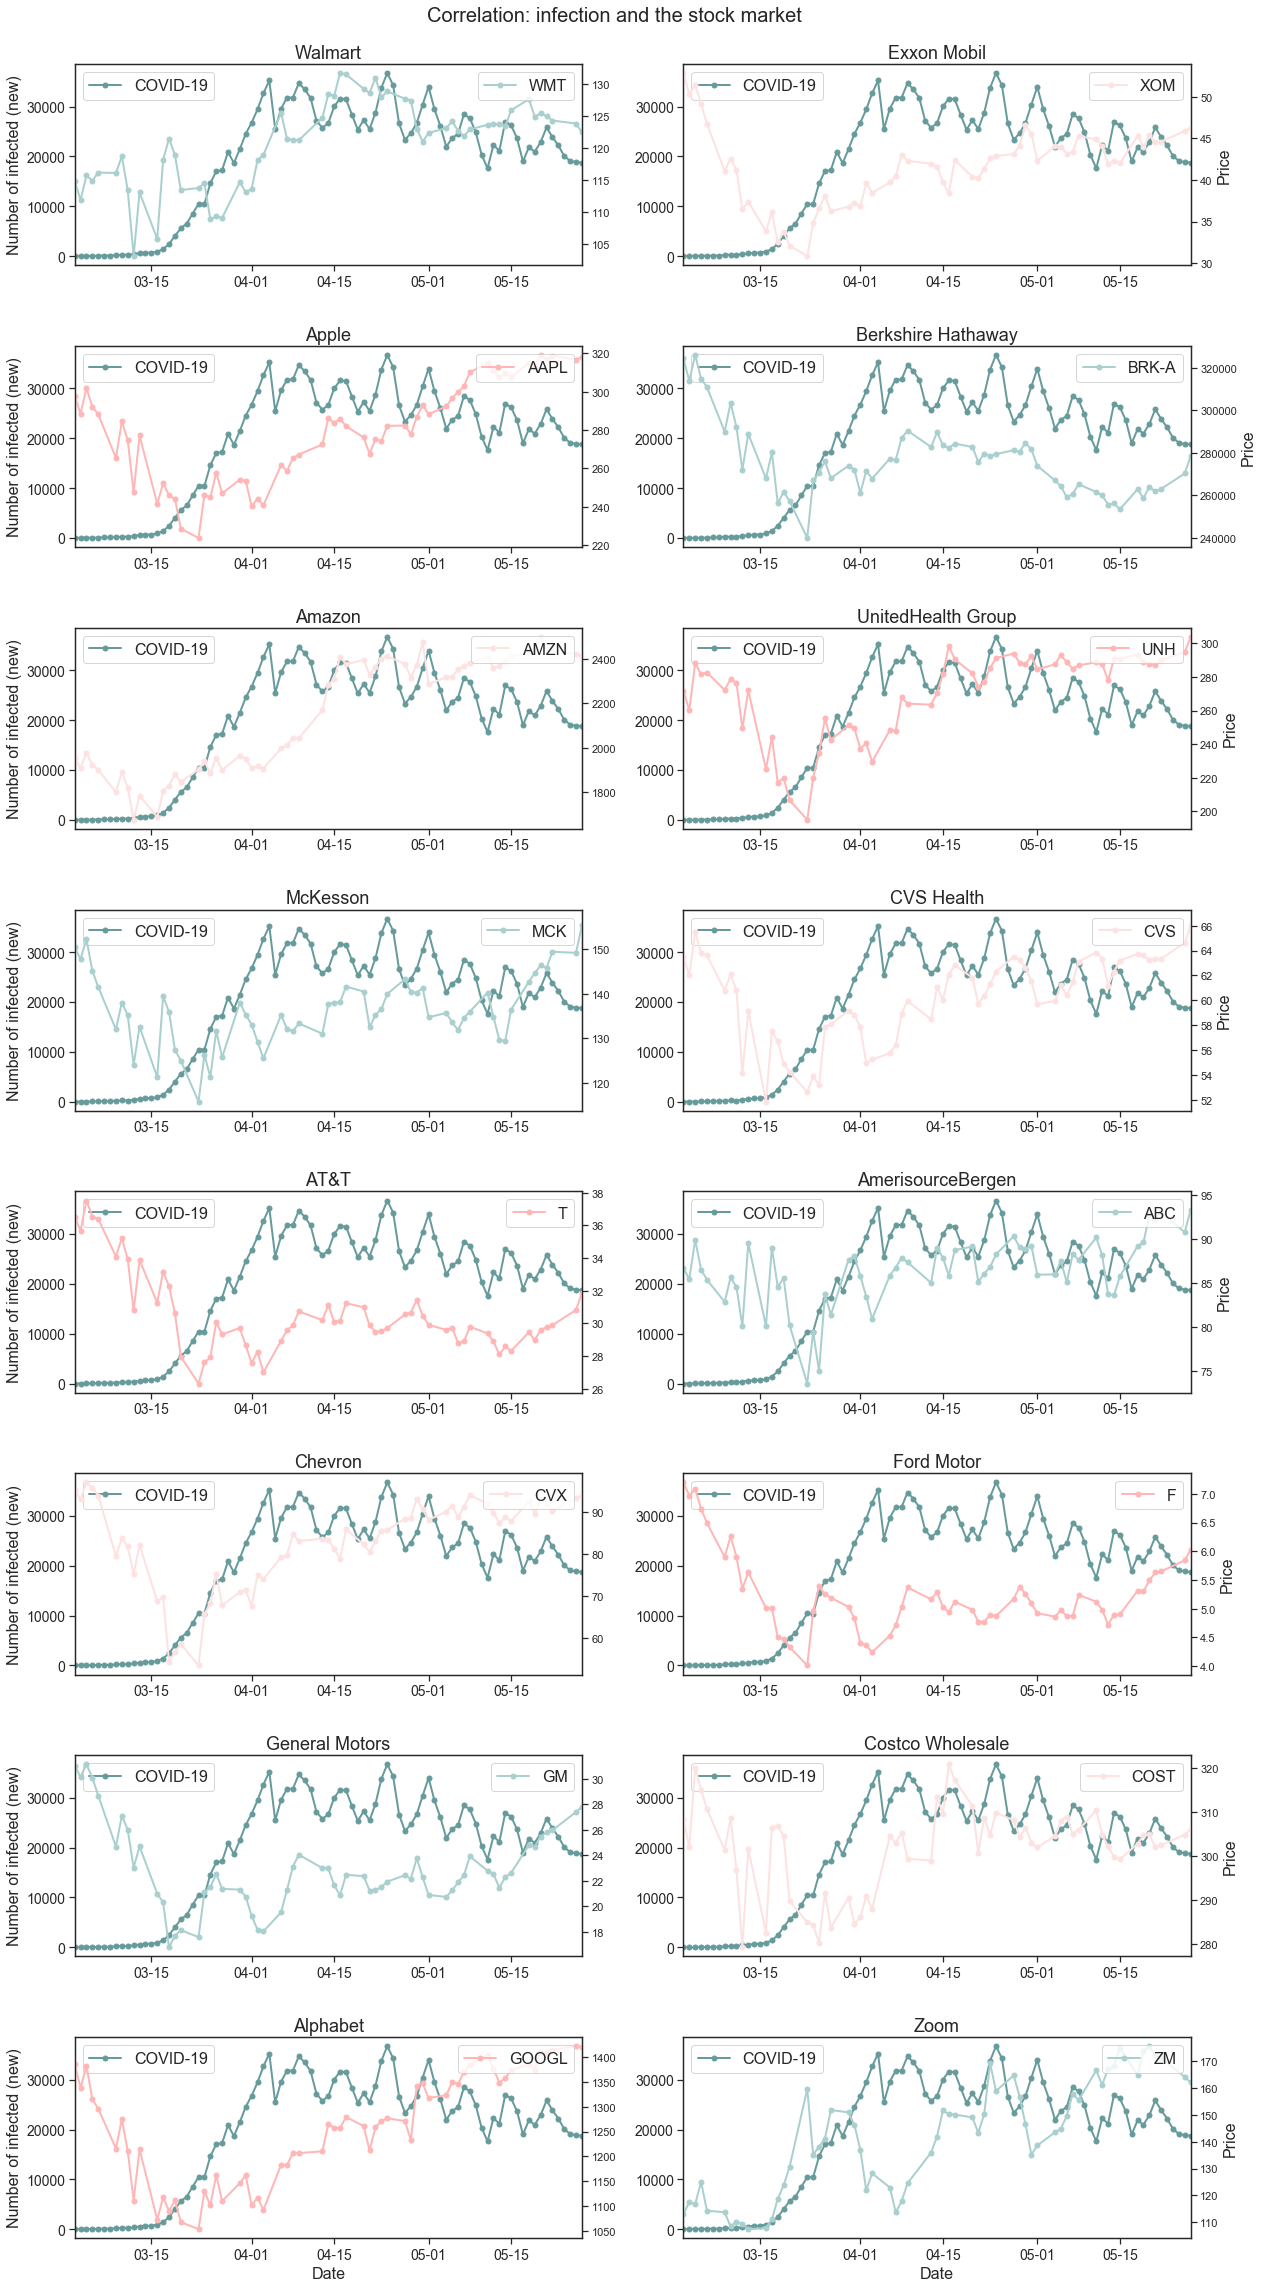

In [40]:
stock_name_list = ['WMT', 'XOM', 'AAPL', 'BRK-A', 'AMZN', 'UNH', 'MCK', 'CVS',
                  'T', 'ABC', 'CVX', 'F', 'GM', 'COST', 'GOOGL', 'ZM']
title_name_list = ['Walmart', 'Exxon Mobil', 'Apple', 'Berkshire Hathaway',
                   'Amazon', 'UnitedHealth Group', 'McKesson', 'CVS Health',
                   'AT&T', 'AmerisourceBergen', 'Chevron', 'Ford Motor', 
                   'General Motors', 'Costco Wholesale', 'Alphabet', 'Zoom']
date_initial = datetime.date(int(2020),int(3),int(2))
figure_stock_list(data_state, stock_name_list, title_name_list, 
                  date_initial, fsize = (10,5), ncol = 2, ms = 5, fs = 18,
                  title = 'United States', country = 'US')